In [1]:
## EDIT:
base_dir = '/glade/work/kjmayer/research/catalyst/TransferLearning/runmean_analysis/artificial_bias/perfectmodel_TLtest/E3SM_analysis/'

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import random
import pandas as pd
import time

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt

import sys
sys.path.append(base_dir+'functions/')
from utils import split_retrain, plot_results

import sys
sys.path.append(base_dir+'train/kerastuner_hpsearch/utils/')
from train_utils import create_ann, scheduler

import sys
sys.path.append(base_dir+'train/kerastuner_hpsearch/hp_results/')
from tfexp_hp import get_hp

2025-01-18 11:17:06.548043: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-18 11:17:07.916356: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Num GPUs Available:  0


In [3]:
EXP_NAME_DATA = 'exp_data_retrain'
hps_retrain = get_hp(EXP_NAME_DATA)

print('Training Members: '+str(hps_retrain['train_mems']))
print('Validation Member: '+str(hps_retrain['val_mems'][0]))
print('Testing Member: '+str(hps_retrain['test_mems'][0]))
print('Lead: '+str(hps_retrain['LEAD']))
print('Region: '+str(hps_retrain['region'][0])+'N x '+str(hps_retrain['region'][1])+'E')

X2train, X2val, _, Y2train, Y2val, _, _ = split_retrain(trainmems = hps_retrain['train_mems'],
                                                          valmem = hps_retrain['val_mems'][0],
                                                          testmem = hps_retrain['test_mems'][0],
                                                          months = [11,12,1,2], # months for X (Y+leadtime are accounted for in function)
                                                          lead = hps_retrain['LEAD']) # 330 or 210

X2val = X2val.reshape((X2val.shape[0],X2val.shape[1]*X2val.shape[2]))
X2train = X2train.reshape((X2train.shape[0],X2train.shape[1]*X2train.shape[2]))
input_shape = X2train.shape[1]

Training Members: ['0201', '0211', '0221', '0231', '0241', '0251', '0261', '0271', '0281']
Validation Member: 0291
Testing Member: 0301
Lead: 14
Region: 30-60N x 170-240E
loading data & saving


In [4]:
# ---------- ANN Hyperparameters ----------
EXP_NAME_RETRAIN = 'exp_2.BO_retrain'
hps_kt_retrain = get_hp(EXP_NAME_RETRAIN)

NLABEL = 2
N_EPOCHS = 1000
dropout = True
PATIENCE = hps_kt_retrain['PATIENCE']
GLOBAL_SEED = hps_kt_retrain['GLOBAL_SEED']

EXP_NAME = 'exp2' # og model
ANN1_HIDDENS = [128]

HIDDENS = hps_kt_retrain['HIDDENS'] # ONLY IF SECOND LAYER!
BATCH_SIZES = hps_kt_retrain['BATCH_SIZES']
LR_INITS = hps_kt_retrain['LR_INITS']
DROPOUT_RATES = hps_kt_retrain['DROPOUT_RATES']
# RIDGES = hps_kt_retrain['RIDGES']

In [5]:
def kt_retrain(hp):
    tf.keras.backend.clear_session() 

    # ----- input of ann -----
    ann_input = keras.Input(shape = input_shape)

    # Number of layers (either 1 or 2)
    num_layers = hp.Choice('num_layers', values=[1, 2])

    x = tf.keras.layers.Dense(ANN1_HIDDENS[0], 
                              activation = 'relu',
                              use_bias = True, 
                              kernel_regularizer = tf.keras.regularizers.l1_l2(l1=0.0, l2=0.0),
                              bias_initializer = tf.keras.initializers.RandomNormal(seed=SEED),
                              kernel_initializer = tf.keras.initializers.RandomNormal(seed=SEED)
                              )(ann_input)
    if dropout:
        x = layers.Dropout(rate = hp.Choice('dropout',values=DROPOUT_RATES))(x)
    
    if num_layers == 2:
        x = tf.keras.layers.Dense(hp.Choice('units2',values=HIDDENS), 
                                  activation = 'relu',
                                  use_bias = True, 
                                  kernel_regularizer = tf.keras.regularizers.l1_l2(l1=0.0, l2=0.0),
                                  bias_initializer = tf.keras.initializers.RandomNormal(seed=SEED),
                                  kernel_initializer = tf.keras.initializers.RandomNormal(seed=SEED)
                                  )(x)
        
    # ----- output -----
    ann_output = tf.keras.layers.Dense(NLABEL,
                                       activation = tf.keras.activations.softmax,
                                       use_bias = True,
                                       kernel_regularizer = tf.keras.regularizers.l1_l2(l1=0.0, l2=0.0),
                                       bias_initializer = tf.keras.initializers.RandomNormal(seed=SEED),
                                       kernel_initializer = tf.keras.initializers.RandomNormal(seed=SEED)
                                      )(x)
    # ----- create unet -----
    ann = keras.Model(ann_input, ann_output, name = 'ann')

    # ----- load and assign original manuscript ann1 weights -----
    annfi_name = 'ann_60Eshift_'+EXP_NAME+'_seed'+str(SEED)+'.h5'
    ann1 = tf.keras.models.load_model(base_dir+'train/saved_models/'+annfi_name)

    ann.layers[1].set_weights(ann1.layers[1].get_weights())

    # ------ Training Hyperparameters ------
    optimizer = tf.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=LR_INITS),)
    loss_func = tf.keras.losses.SparseCategoricalCrossentropy()
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name="sparse_categorical_accuracy", dtype=None)]                             

    # ------ Compile Model -----
    ann.compile(optimizer = optimizer,
                loss = loss_func,
                metrics = metrics)
    
    return ann

Trial 90 Complete [00h 00m 35s]
val_loss: 0.6757137775421143

Best val_loss So Far: 0.6749817132949829
Total elapsed time: 01h 25m 39s
Elapsed time during fit = 5138.95 seconds

Best Trial ID: 14
Number of Layers: 2
First Layer: 128
Second Layer: 32
Learning Rate: 0.0001
Dropout: 0.5
Batch Size: 1028


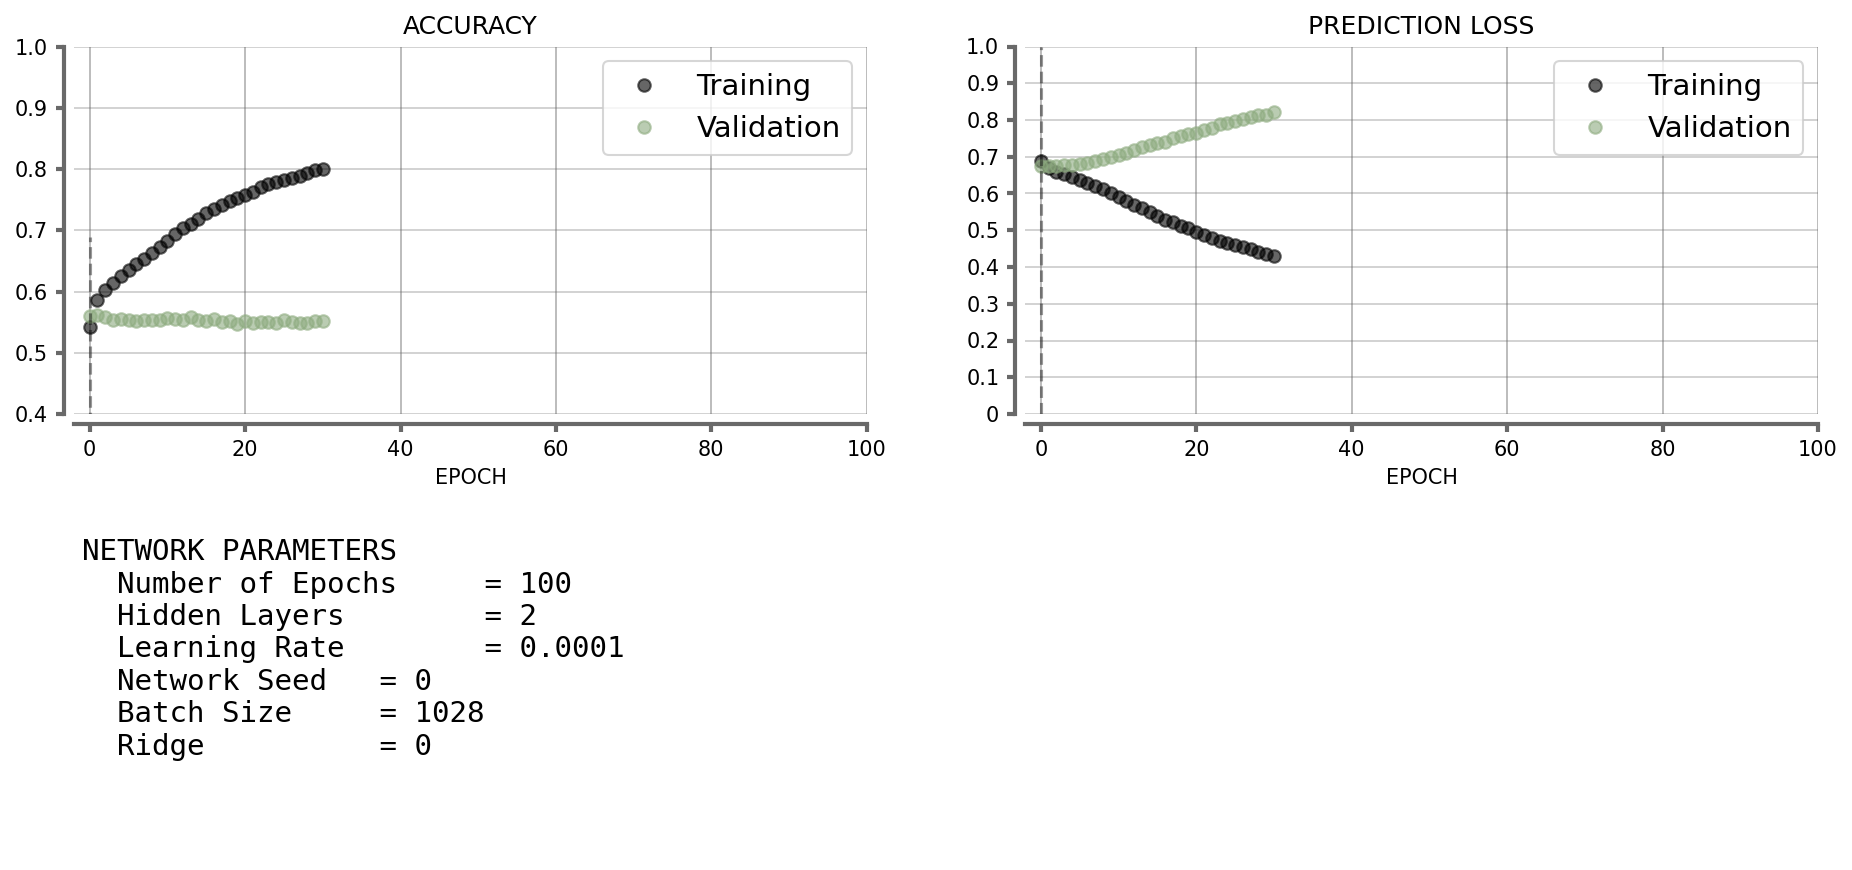

Best Trial ID: 11
Number of Layers: 2
First Layer: 128
Second Layer: 32
Learning Rate: 0.0001
Dropout: 0.2
Batch Size: 1028


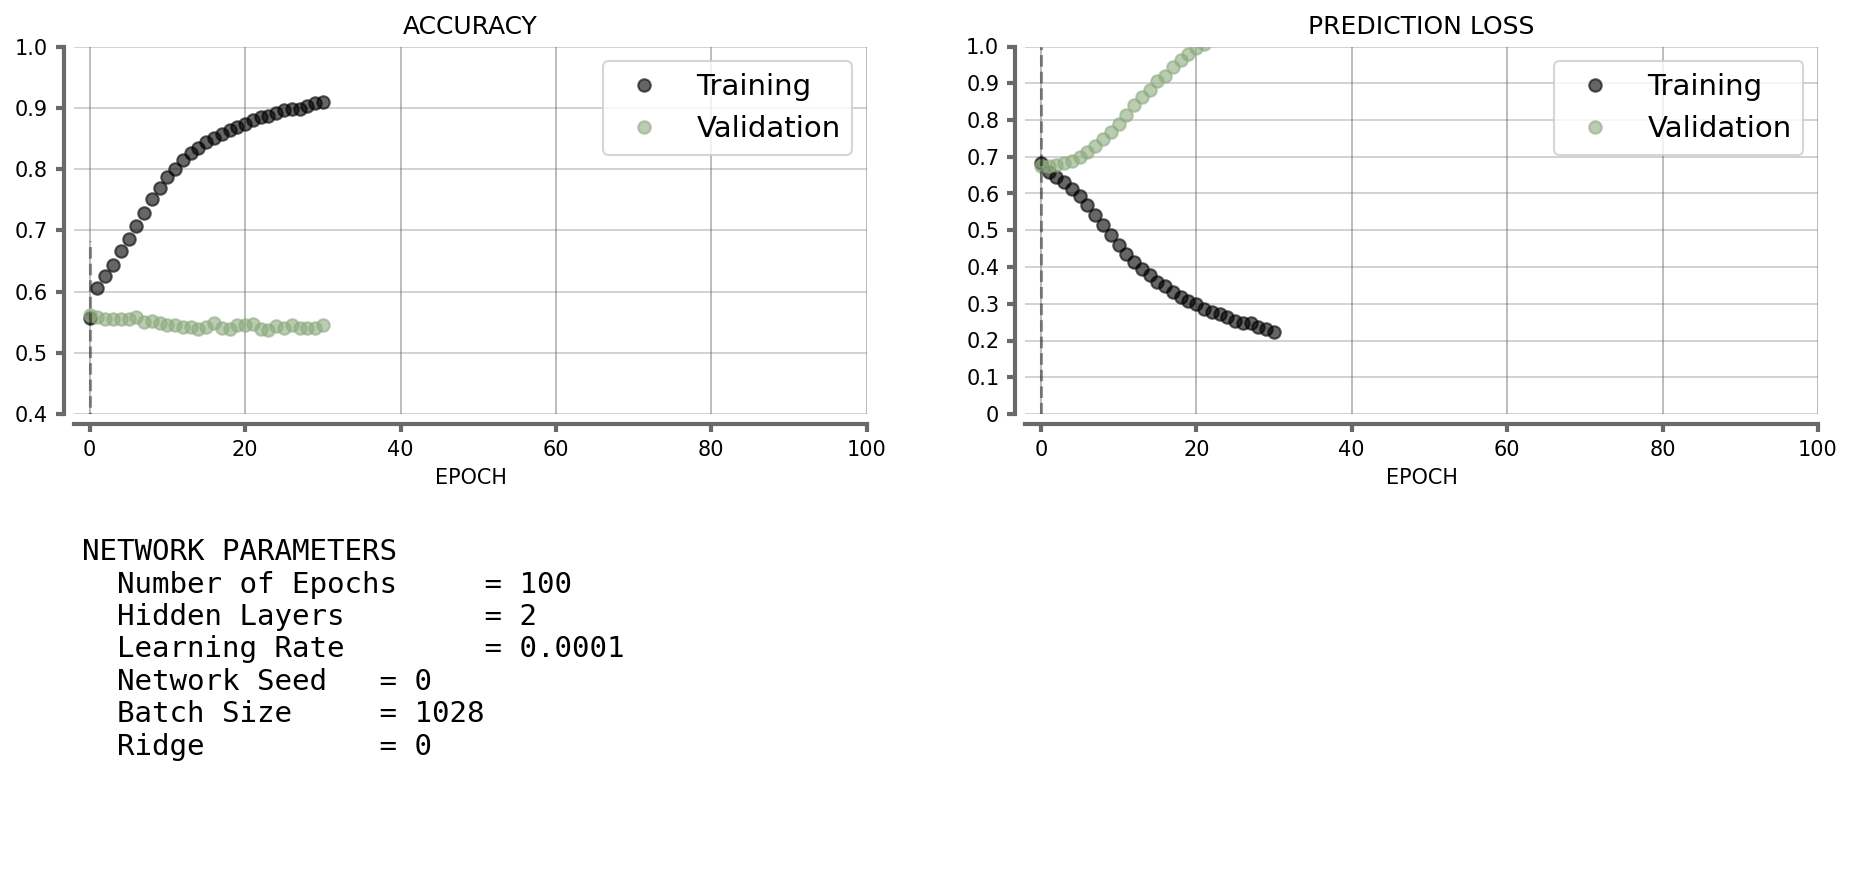

Best Trial ID: 15
Number of Layers: 2
First Layer: 128
Second Layer: 32
Learning Rate: 1e-05
Dropout: 0.2
Batch Size: 1028


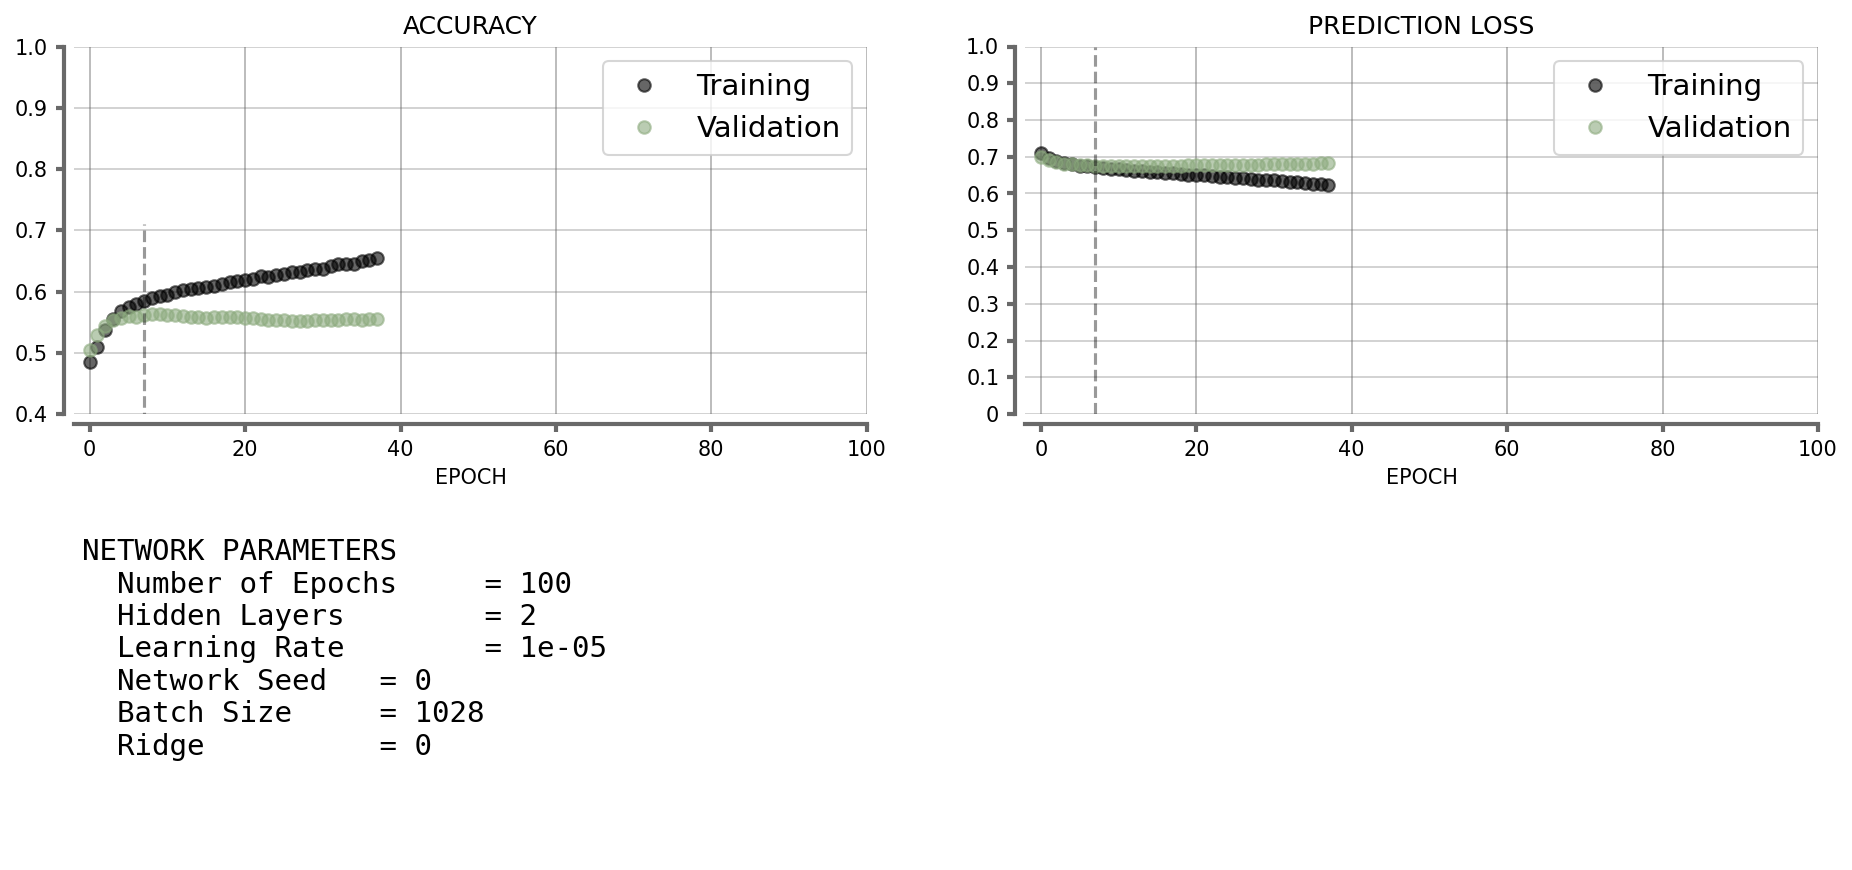

Best Trial ID: 16
Number of Layers: 2
First Layer: 128
Second Layer: 32
Learning Rate: 1e-05
Dropout: 0.2
Batch Size: 1028


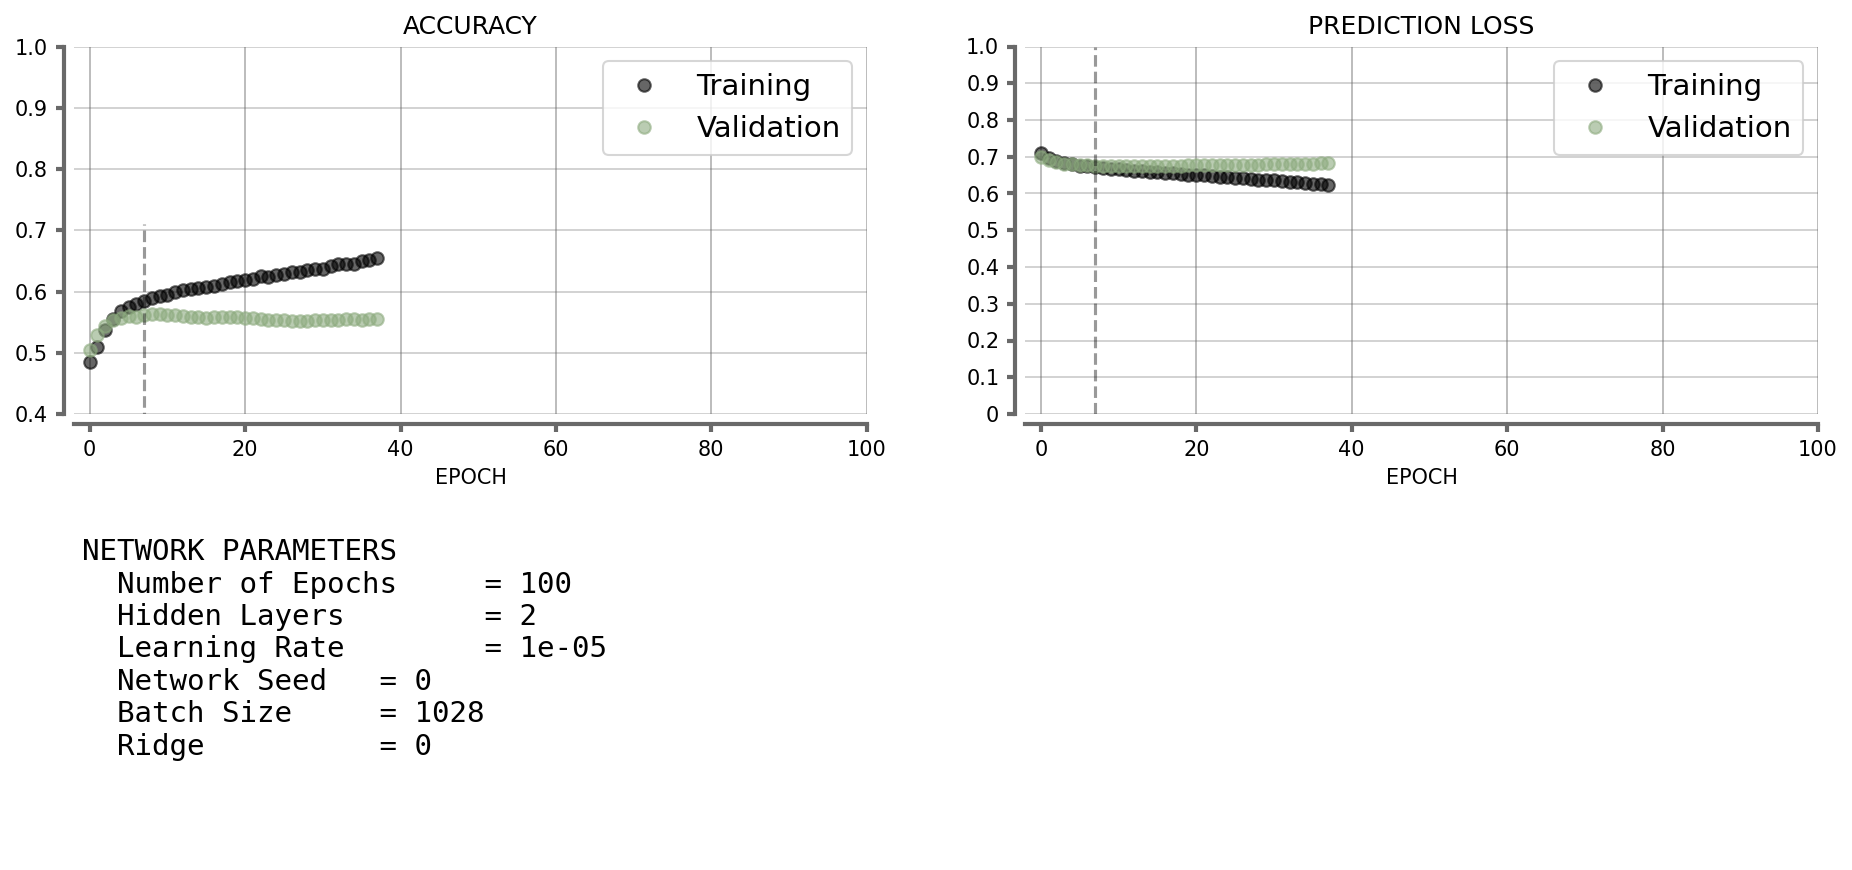

Best Trial ID: 19
Number of Layers: 2
First Layer: 128
Second Layer: 32
Learning Rate: 1e-05
Dropout: 0.2
Batch Size: 1028


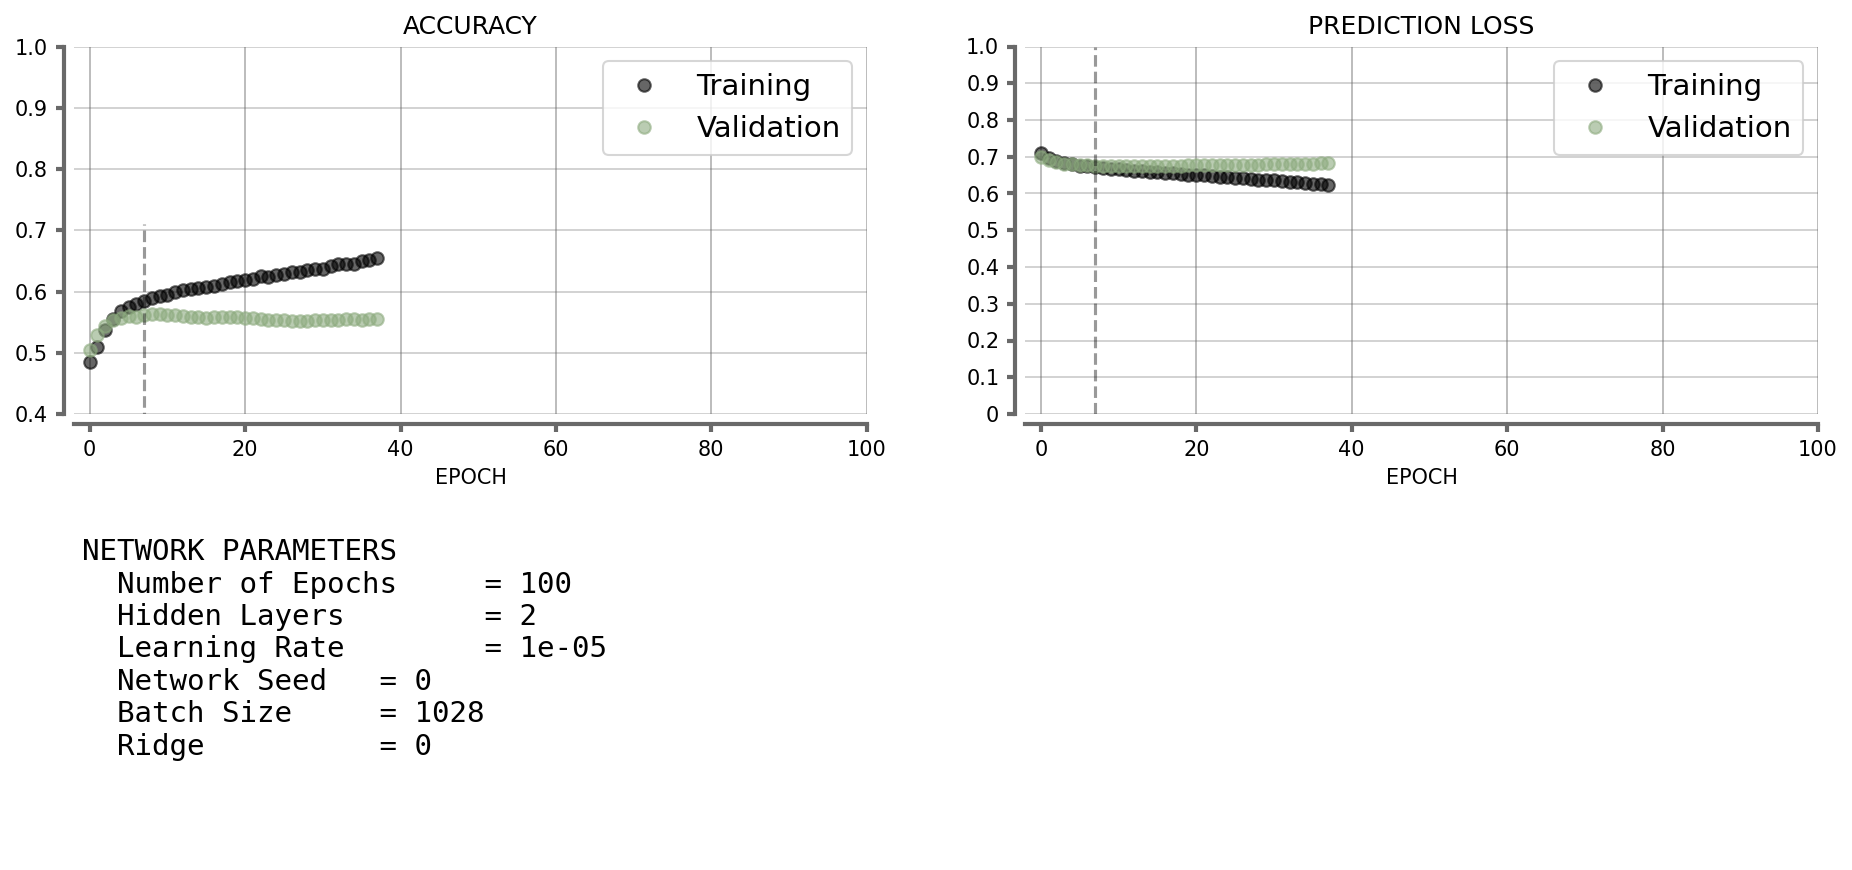

In [6]:
np.random.seed(GLOBAL_SEED)
random.seed(GLOBAL_SEED)
tf.random.set_seed(GLOBAL_SEED)
SEED = 0

for BATCH_SIZE in BATCH_SIZES[1:]:
    tuner = kt.BayesianOptimization(kt_retrain,
                                    objective='val_loss',
                                    max_trials=90,
                                    alpha=0.0001,
                                    beta=3, # more explorative than default=2.6
                                    directory='hp_results',
                                    project_name='hp_exp'+EXP_NAME_RETRAIN[4:]+'.'+str(BATCH_SIZE))

    # ----- Callbacks -----
    ES = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'auto', min_delta = 0.001,
                                          patience = PATIENCE, verbose = 0, restore_best_weights = True)
    start_time = time.time()
    tuner.search(X2train,Y2train,
                 validation_data = [X2val,Y2val],
                 epochs = N_EPOCHS,
                 batch_size = BATCH_SIZE,
                 shuffle = True,
                 callbacks = [ES])
    stop_time = time.time()
    tf.print(f"Elapsed time during fit = {(stop_time - start_time):.2f} seconds\n")

    # Get the optimal hyperparameters
    best_hps=tuner.get_best_hyperparameters(num_trials=5)
    for b_hps in range(len(best_hps)):
        trial_id = tuner.oracle.get_best_trials(num_trials=5)[b_hps].trial_id
        print(f"""Best Trial ID: {trial_id}""")
        print(f"""Number of Layers: {best_hps[b_hps].get('num_layers')}""")
        print(f"""First Layer: {128}""")
        if best_hps[b_hps].get('num_layers') == 2:
            print(f"""Second Layer: {best_hps[b_hps].get('units2')}""")
        print(f"""Learning Rate: {best_hps[b_hps].get('learning_rate')}""")
        print(f"""Dropout: {best_hps[b_hps].get('dropout')}""")
        print(f"""Batch Size: {BATCH_SIZE}""")
        
        best_model = tuner.hypermodel.build(best_hps[b_hps])

        history = best_model.fit(X2train, Y2train,
                                 validation_data = [X2val,Y2val],
                                 epochs = N_EPOCHS,
                                 batch_size = BATCH_SIZE,
                                 shuffle = True,
                                 verbose=0,
                                 callbacks = [ES])
        
        #----- PLOT THE RESULTS -----
        plot_results(
            history,
            exp_info=(100, best_hps[b_hps].get('num_layers'), best_hps[b_hps].get('learning_rate'), BATCH_SIZE, SEED, PATIENCE, 0),
            showplot=True
        ) 
    
        annfi_name = 'ann2_60Eshift_'+EXP_NAME_RETRAIN+'_'+str(BATCH_SIZE)+'_modelnum'+str(b_hps+1)+'outof5_seed'+str(SEED)+'.h5'
        best_model.save(base_dir+'train/kerastuner_hpsearch/hp_results/hp_exp2.BO_retrain_models/'+annfi_name)  